In [225]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint, random
from IPython.display import Image

# Defense mechanics

A damage received can pass through a maximum of two defense mechanisms:
- The probability of dodging
- Armor damage reduction

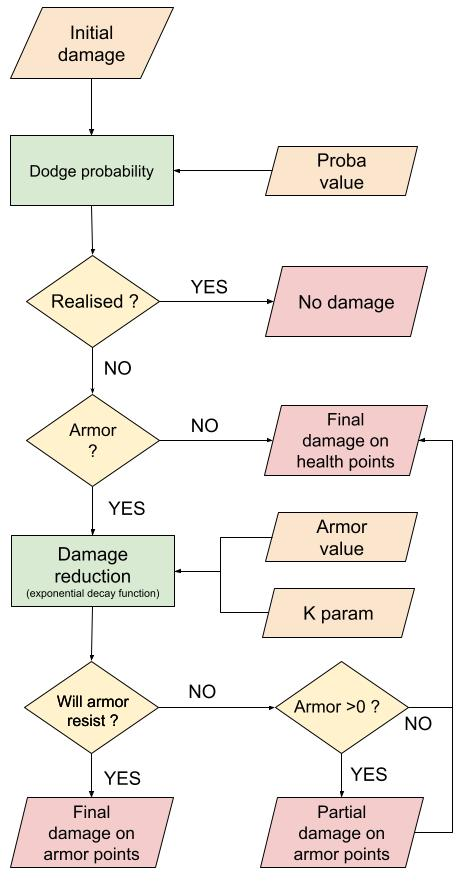

In [226]:
Image(filename='nb_figures/damage_algo.jpg')

## Dodge chance

Damage received does not directly affect armor points or heal points but first passes through a function that determines whether the hit received will be dodged based on a dodge probability value. If the hit is dodged, no damage is applied.

In [227]:
# Tests a probability and returns True if it's realized, 
# False otherwise.
def check_proba(proba):
    proba = proba / 100
    rng_num = random()
    if rng_num < proba:
        return True
    else:
        return False

In [228]:
# Simulation
hits = 25
dam_list = []
proba = 33
for i in range(1, hits+1):
    if check_proba(proba): # Dodged
        dam_list.append(0)
    else: # Damage recieved
        dam_list.append(1)

x = np.array(list(range(1, hits+1)))

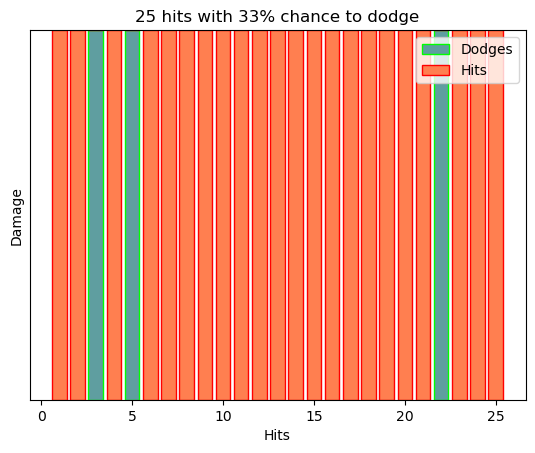

In [213]:
# Simulation plot
dodges_array = np.array(dam_list) == 0
hits_array = np.array(dam_list) == 1

dodge_color = "cadetblue"
hit_color = "coral"

# Dodge bars
plt.bar(x, dodges_array, 
        color=dodge_color,
        edgecolor="lime", 
        label="Dodges")

# Hits bars
plt.bar(x, hits_array, 
        bottom=dodges_array, 
        edgecolor="red", 
        color=hit_color, 
        label="Hits")

plt.legend()
plt.xlabel("Hits")
plt.yticks([])
plt.ylabel("Damage")
plt.title(f"{hits} hits with {proba}% chance to dodge")
plt.show()

## Armor damage reduction

Illustration of armor performance at 50 damage.
 
The initial damage value is passed through a decreasing exponential function to determine the final damage value.

In [214]:
damage = 50
armor = 150
k = .0217 # Decay rate

> **Parameter k** : *The decay rate. The greater the k, the faster the decay. We could say that k represents the “speed” at which the function decreases.* 
> 
> *The balance can be delicate because too high, a k value could make the armor far too powerful at its initial values. Conversely, too low, a k value would make armor points too volatile. In our configuration, a k value between 0.04 and 0.05 seems to give balanced armor performance.*

In [215]:
x = np.linspace(0, armor, armor)
y = damage * np.exp(-k * x)

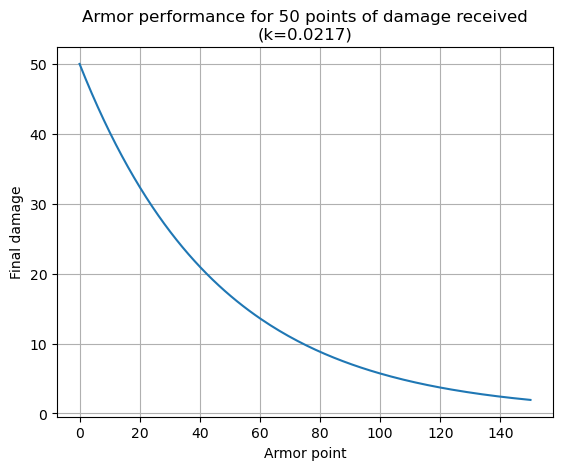

In [216]:
plt.plot(x, y)
plt.xlabel("Armor point")
plt.ylabel("Final damage")
plt.title(f"Armor performance for 50 points of damage received\n(k={k})")
plt.grid(True)
plt.show()

The final damage value corresponds to the damage that the armor could not absorb, so the armor points will be reduced by this same value. Thus, as the armor takes damage, its value decreases, making it less effective.

If a damage value is greater than the armor points, then the armor breaks and the unabsorbed damage values directly ​​affect the player's life points.

We can do a simulation of random hits received by the armor to illustrate its performance

In [217]:
# Simulation of a succession random hits received by the armor
k = .04
armor = 100
damage_range = (1, 50)
hits_array = 0 # Number of hits
arm_list = [armor] # List of armor values
dam_list = [] # List of random damage values

while True :
    damage = randint(damage_range[0], damage_range[1])
    dam_list.append(damage)
    x = np.linspace(0, armor, int(armor))
    y = damage * np.exp(-k * x)
    dam = y[-1] # Last value = first armor point
    hits_array += 1
    
    if dam < armor:
        #print(f"Hit {hits} | {damage} dam | armor : {round(armor, 3)} | armor damage : {round(dam, 3)}")
        armor -= dam
        arm_list.append(round(armor, 3))
    else:
        #print(f"Hit {hits} | {damage} dam | armor : {round(armor, 3)} | armor damage : {round(dam, 3)}")
        #print(f"BROKEN ARMOR -> -{round(dam-armor, 3)} hp")
        break

In [218]:
# Creating the axes
x = np.linspace(1, hits_array, hits_array)
y = np.array(arm_list)
z = np.array(dam_list)

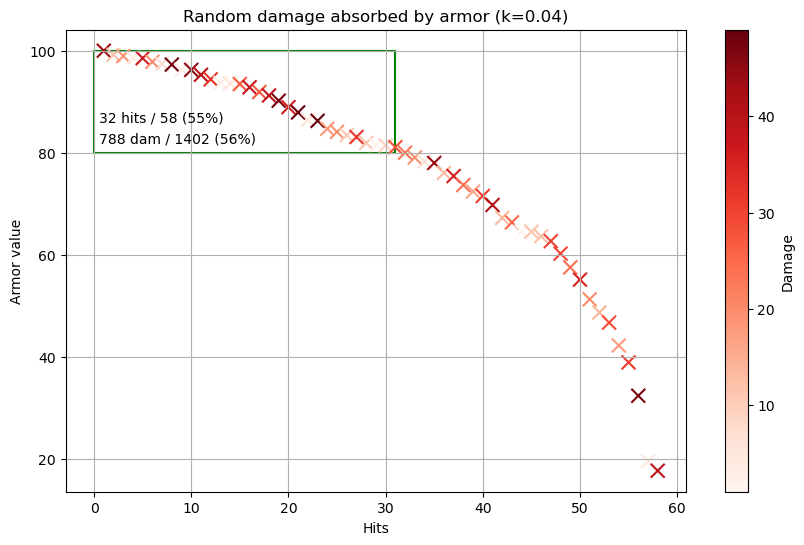

In [219]:
plt.figure(figsize=(10, 6))

# Retrieving the x coordinate where y = 80
mask = (y >= 80) & (y <= 100)
y_slice = y[mask]
x_idx = np.where(y == y_slice[-1])[0][0]

# Tracing the rectangle
rect = patches.Rectangle((0, 80), x_idx, 20, 
                         edgecolor="green", 
                         facecolor="none",
                         linewidth=1.5)
plt.gca().add_patch(rect)

# Hits stats
sliced_hits = len(y_slice)
total_hits = len(x)
sliced_hits_rate = int((sliced_hits / total_hits) * 100)

# Damage stats
sliced_damage = sum(dam_list[0:x_idx+1])
total_damage = sum(dam_list)
sliced_damage_rate = int((sliced_damage / total_damage) * 100)

# Text placement
plt.text(0.5, 86, f"{sliced_hits} hits / {total_hits} ({sliced_hits_rate}%)")
plt.text(0.5, 82, f"{sliced_damage} dam / {total_damage} ({sliced_damage_rate}%)")

# Scatter plot with color depending on z
scatter = plt.scatter(x, y, c=z, cmap='Reds', s=100, marker='x')

# Adding the color bar
plt.colorbar(scatter, label='Damage')

# Label titles
plt.title(f"Random damage absorbed by armor (k={k})")
plt.xlabel("Hits")
plt.ylabel("Armor value")

# Other options
plt.grid(True)

plt.show()

In our configuration :
- **Parameter k** : 0.04
- **Full armor** : 100
- **Random damage** : between 1 and 50

Several observations can be made :
- The armor can withstand a little over 50 hits before completely giving way. 
- More than half of hits are taken between 100 and 80 armor (*green rectangle*)
- More than half of the total damage is absorbed in that range
- Beyond that range, each hit becomes more and more impactful on the armor value decay.

This is a good indication of the high performance of the armor in its high values. 

## Global simulation

Simulation of hits received by combining dodge chance and armor

In [220]:
# Testing a dodge probability
def dodge(proba):
    proba = proba / 100
    rng_num = random()
    if rng_num < proba:
        return True
    else:
        return False

# Damage mitigation
def armor(init_dam, armor_val, k):
    final_dam = init_dam * np.exp(-k * armor_val)
    return final_dam

# Coupling the dodge probability with armor
def defense(init_dam, dodge_proba, armor_val, k):
    if dodge(dodge_proba):
        final_dam = 0
        return final_dam
    else:
        final_dam = armor(init_dam, armor_val, k)
        return final_dam

In [221]:
# Initial values
dam_range = (1, 50)
dodge_proba = 33
init_armor_val = 100
init_hp_val = 350
k_val = .04

armor_val = init_armor_val
hp_val = init_hp_val

armor_val_list = []
hp_val_list = []
dodge_list = []

while hp_val > 0:
    dam = randint(dam_range[0], dam_range[1])
    
    # The hit was dodged
    if dodge(dodge_proba):
        armor_val_list.append(armor_val)
        hp_val_list.append(hp_val)
        dodge_list.append(len(armor_val_list)+1)
        
    # Dodge failed
    else:
        # Armor can still absorb damage
        if armor_val > 0:
            final_dam = armor(dam, armor_val, k_val)
            # Armor can take the full damage
            if final_dam < armor_val:
                armor_val -= final_dam
                armor_val_list.append(armor_val)
                hp_val_list.append(hp_val)
                
            # Armor can't absorb the full damage
            else:
                # Armor can only take a fraction of the damage
                if armor_val >= 0:
                    extra_dam = final_dam - armor_val
                    armor_val -= armor_val
                    hp_val -= extra_dam
                    armor_val_list.append(armor_val)
                # Armor already broken
                else:
                    armor_val = 0
                    armor_val_list.append(armor_val)
                hp_val_list.append(hp_val)
        
        # Armor is broken, health points will be affected     
        else:
            hp_val -= dam
            if hp_val >= 0:
                hp_val_list.append(hp_val)
            else:
                hp_val = 0
                hp_val_list.append(hp_val)
            armor_val_list.append(armor_val)

In [222]:
# Total number of hits received
hits = list(range(1, len(armor_val_list)+1))

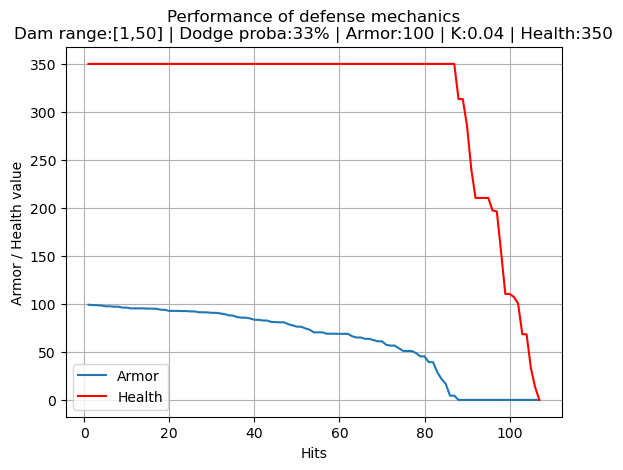

In [223]:
plt.plot(hits, armor_val_list, label="Armor")
plt.plot(hits, hp_val_list, color="red", label="Health")

""" for xvline in dodge_list:
    plt.axvline(x=xvline, color='green', linestyle='--', linewidth=0.7) """

plt.title(f"Performance of defense mechanics\nDam range:[{dam_range[0]},{dam_range[1]}] | Dodge proba:{dodge_proba}% | Armor:{init_armor_val} | K:{k} | Health:{init_hp_val}")
plt.xlabel("Hits")
plt.ylabel("Armor / Health value")

plt.legend()
plt.grid(True)

plt.show()

By coupling the dodge probability, armor and health points, with the parameters defined in the figure, a little more than 80 hits can be taken before the character's health points reach zero. We can notice small plateaus on the Armor and Health curves, they correspond to the dodges made.

# Attack mechanics

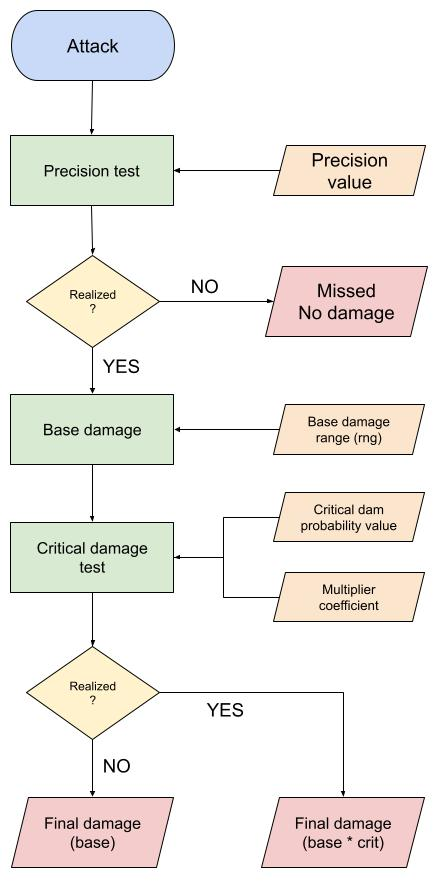

In [224]:
Image(filename='nb_figures/attack_algo.jpg')